## Import Libraries

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import re
import datetime

from pyspark.sql import SQLContext, SparkSession
import  pyspark.sql.functions as F
import findspark
findspark.init()
import pyspark
from sklearn.model_selection import train_test_split


from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer
from pyspark.sql.types import ArrayType, StringType

In [2]:
#Starting Spark Session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .config("spark.driver.memory","16G")\
    .config('spark.executor.memory', '8G') \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.0") \
    .getOrCreate()
spark

### Import Restaurant Attributes

In [3]:
rest_attrs_file = '../data/input/rest_attributes/rest_attrs_compiled.json'
df_rest_attrs =  spark.read.option("multiLine", "true").option("mode", "PERMISSIVE").json(rest_attrs_file)
df_rest_attrs = df_rest_attrs.withColumn('rest_type', F.regexp_replace(F.lower(F.col('rest_type')), ' restaurant', ''))
df_rest_attrs = df_rest_attrs.withColumn('rest_type', F.regexp_replace(F.lower(F.col('rest_type')), ' shop', ''))

print('Total Number of Restaurants',df_rest_attrs.count())
raw_rest_types = df_rest_attrs.select('rest_type').distinct().count()
print('Total unique/distinct restaurant types = ', raw_rest_types)

Total Number of Restaurants 59835
Total unique/distinct restaurant types =  689


In [4]:
tot = df_rest_attrs.count()
df_rest_attrs.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show(n=20 ,truncate=False)

+-----------+-------------+-------------------+
|rest_type  |cnt_per_group|perc_of_count_total|
+-----------+-------------+-------------------+
|restaurant |9992         |16.69925628812568  |
|mexican    |4073         |6.807052728336258  |
|pizza      |2862         |4.783153672599649  |
|null       |2401         |4.0127015960558206 |
|fast food  |2328         |3.89069942341439   |
|sandwich   |2235         |3.735271997994485  |
|chinese    |2145         |3.584858360491351  |
|american   |1930         |3.225536893122754  |
|italian    |1693         |2.829447647697836  |
|coffee     |1693         |2.829447647697836  |
|seafood    |995          |1.6629063257290881 |
|japanese   |970          |1.621124759755996  |
|thai       |922          |1.5409041530876577 |
|bar & grill|921          |1.539232890448734  |
|sushi      |887          |1.4824099607253278 |
|hamburger  |848          |1.4172307178073034 |
|chicken    |828          |1.3838054650288292 |
|cafe       |717          |1.19829531210

###  FIltering and Categorizing Restaurant Types

In [5]:
df_attrs_clean = df_rest_attrs.withColumn('rest_type', 
              F.when(F.lower(F.col('rest_type')).rlike('taco|mexican|burrito'), F.lit('mexican'))\
              .when(F.lower(F.col('rest_type')).rlike('bar|pub|brewery|beer|gastropub|brasserie'), F.lit('bar'))\
              .when(F.lower(F.col('rest_type')).rlike('pizza'), F.lit('pizza'))\
              .when(F.lower(F.col('rest_type')).rlike('irish|fish & chips|fish and chips'), F.lit('irish'))\
              .when(F.lower(F.col('rest_type')).rlike('indian|pakistan|nepalese'), F.lit('indian'))\
              .when(F.lower(F.col('rest_type')).rlike('chinese|dim|sichuan|noodle|mandarin|shang|hong|\
                                                      |hot pot|餐馆|cantonese|dumpling'), F.lit('chinese'))\
              .when(F.lower(F.col('rest_type')).rlike('american|us|hot dog|diner|southern|cajun'), F.lit('american'))\
              .when(F.lower(F.col('rest_type')).rlike('ramen|japanese|izakaya'), F.lit('japanese'))\
            .when(F.lower(F.col('rest_type')).rlike('sushi'), F.lit('sushi'))\
              .when(F.lower(F.col('rest_type')).rlike('steak'), F.lit('steak'))\
              .when(F.lower(F.col('rest_type')).rlike('thai|cambodia'), F.lit('thai'))\
              .when(F.lower(F.col('rest_type')).rlike('chicken'), F.lit('fast food'))\
              .when(F.lower(F.col('rest_type')).rlike('vietnamese|pho'), F.lit('vietnamese'))\
            .when(F.lower(F.col('rest_type')).rlike('italian|pasta'), F.lit('italian'))\
                                          .when(F.lower(F.col('rest_type')).rlike('portuguese|salvadoran|peru|\
                                                    |cuban|brazilian|honduran|latin|guatemalan|ecuadorian|\
                                                      |argentinian|venezuelan|colombian|dominican|nicaraguan')\
                    , F.lit('latin american'))\
                                     
              
              .when(F.lower(F.col('rest_type')).rlike('greek|gyro|falafel|middle eastern|afghani|persian|\
                                                  |halal|kebab|mediterranean|middle eastern|lebanese'), F.lit('mediterranean'))\
              .when(F.lower(F.col('rest_type')).rlike('korean|한식당|음식점'), F.lit('korean'))\
              .when(F.lower(F.col('rest_type')).rlike('french|crêperie|crepe'), F.lit('french'))\
              .when(F.lower(F.col('rest_type')).rlike('lounge|bistro'), F.lit('bistro'))\
              .when(F.lower(F.col('rest_type')).rlike('burger|sandwich'), F.lit('burger'))\
              .when(F.lower(F.col('rest_type')).rlike('brunch|breakfast|pancake'), F.lit('brunch'))\
              .when(F.lower(F.col('rest_type')).rlike('coffee|cafe|bake|bakery|donut|bagel'), F.lit('cafe&bakery'))\
              .when(F.lower(F.col('rest_type')).rlike('southern|soul food'), F.lit('southern'))\
              .when(F.lower(F.col('rest_type')).rlike('spanish|tapas'), F.lit('spanish'))\
              .when(F.lower(F.col('rest_type')).rlike('asian'), F.lit('asian'))\
              .when(F.lower(F.col('rest_type')).rlike('european|german|polish|belgian|british|swedish|irish'), F.lit('european'))\
              .when(F.lower(F.col('rest_type')).rlike('african'), F.lit('african'))\
              .when(F.lower(F.col('rest_type')).rlike('vegan|vegetarian'), F.lit('vegetarian'))\
                .when(F.lower(F.col('rest_type')).rlike('stand|venue|club|mall|alley|market|store|association|\
                                                      |station|juice|ice cream|center|theater|cater|court|fuel|\
                                                      |tobacco|arcade|producer|winery|yogurt|hall|school|grovery|service|\
                                                      |apartment|agency|organization|atm|estate|office|casino|\
                                                      |company|consultant|gift|deli')\
                    , F.lit('remove')) \
                .otherwise(F.lit(F.col('rest_type')))              
                         )
rest_types_not_categorized = ['restaurant', 'takeout', 'fine dining','grill','organic', 'vegetarian', 'brunch',
                              'lunch', 'health food','asian','family', 'delivery']
df_attrs_clean = df_attrs_clean.where('rest_type != "remove"')
df_attrs_clean = df_attrs_clean.filter(~df_attrs_clean.rest_type.isin(rest_types_not_categorized))
rest_types = df_attrs_clean.select('rest_type').distinct().count()
print('Total unique/distinct restaurant types after cleaning = ', rest_types)

Total unique/distinct restaurant types after cleaning =  306


### Top 50 Restaurant Types by Percentage of Total

In [6]:
tot = df_attrs_clean.count()
df_attrs_clean.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show(n=50 ,truncate=False)

+--------------+-------------+--------------------+
|rest_type     |cnt_per_group|perc_of_count_total |
+--------------+-------------+--------------------+
|american      |5152         |12.10924646265219   |
|mexican       |4589         |10.78597282940817   |
|fast food     |3680         |8.649461759037278   |
|bar           |3536         |8.311004559770602   |
|pizza         |3492         |8.207587082216895   |
|burger        |3083         |7.246274620410849   |
|cafe&bakery   |2943         |6.917219010012691   |
|chinese       |2696         |6.336670897381658   |
|italian       |1733         |4.073238377285762   |
|latin american|1429         |3.358717623278334   |
|mediterranean |1369         |3.2176937902505522  |
|japanese      |1336         |3.1401306820852724  |
|seafood       |995          |2.338645231044046   |
|thai          |942          |2.2140741785361726  |
|indian        |728          |1.7110891740704177  |
|vietnamese    |549          |1.2903680722042026  |
|korean     

## Top 20 Restaurant Categories

In [7]:
tot = df_attrs_clean.count()
top_rest_categories = df_attrs_clean.groupBy("rest_type") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()).limit(19).select('rest_type').collect()
top_19_rest_categories = [row.rest_type for row in top_rest_categories]
df_attrs_top = df_attrs_clean.withColumn('rest_type_clean', 
                                        F.when(F.col('rest_type').isin(top_19_rest_categories), F.lit(F.col('rest_type')))
                                        .otherwise(F.lit('others')))
tot = df_attrs_top.count()
df_attrs_top.groupBy("rest_type_clean") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show()

+---------------+-------------+-------------------+
|rest_type_clean|cnt_per_group|perc_of_count_total|
+---------------+-------------+-------------------+
|       american|         5152|  12.10924646265219|
|        mexican|         4589|  10.78597282940817|
|      fast food|         3680|  8.649461759037278|
|            bar|         3536|  8.311004559770602|
|          pizza|         3492|  8.207587082216895|
|         others|         3239|  7.612936586283083|
|         burger|         3083|  7.246274620410849|
|    cafe&bakery|         2943|  6.917219010012691|
|        chinese|         2696|  6.336670897381658|
|        italian|         1733|  4.073238377285762|
| latin american|         1429|  3.358717623278334|
|  mediterranean|         1369| 3.2176937902505522|
|       japanese|         1336| 3.1401306820852724|
|        seafood|          995|  2.338645231044046|
|           thai|          942| 2.2140741785361726|
|         indian|          728| 1.7110891740704177|
|     vietna

### Import Review Files

In [8]:
op_path = '../data/input/review_files/'
op_files = [op_path + f for f in os.listdir(op_path) ]
df_reviews = spark.read.parquet(*op_files)
print('Total Number of Reviews = ',df_reviews.count())

Total Number of Reviews =  15846441


In [9]:
df_clean = df_reviews.drop_duplicates(subset = ['place_id', 'review_id'])
print('Count after dropping duplicate reviews= ',df_clean.count())

df_filter = df_clean.withColumn('Review_Length', F.length('review')).filter(F.col('Review_Length') >30)
print('Count after filtering out low length reviews= ',df_filter.count())

df_group_place_id = df_filter.groupby('place_id').agg(F.collect_list('review').alias("reviews"))
df_group_place_id_combined = df_group_place_id.withColumn("reviews", F.concat_ws(". ", "reviews"))

df_combined = df_attrs_top.select('place_id', 'rest_type_clean','rest_summary')\
                .join(df_group_place_id_combined.select('place_id', 'reviews'), 'place_id', 'inner')
print('Count of Combined dataframe with Top 20 restaurant categories = ', df_combined.count())
df_combined.show(n=3, truncate = 50)

Count after dropping duplicate reviews=  15167294
Count after filtering out low length reviews=  6762799
Count of Combined dataframe with Top 20 restaurant categories =  40202
+---------------------------+---------------+--------------------------------------------------+--------------------------------------------------+
|                   place_id|rest_type_clean|                                      rest_summary|                                           reviews|
+---------------------------+---------------+--------------------------------------------------+--------------------------------------------------+
|ChIJ-0J6oCi32YgRhhxfaT9WcvQ|       american|                                           Dine-in|A place to be yet discovered. Amazing decor, mu...|
|ChIJ-1UjJEBgwokR6th7K9XY7OM|        chinese|An extensive Cantonese Chinese menu served in a...|Service was so bad, waiters ignore you when you...|
|ChIJ-1ZeYqWbTYcRhn9VUfuE_os|  mediterranean|                                       

In [11]:
stopwordList = ["good","food","yet", "place","translated", "google", 'great', 'delicious', 'like' ] 
stopwordList.extend(StopWordsRemover().getStopWords())
df_combined = df_combined.withColumn('reviews', F.lower(F.col('reviews')))
df_reviews_rem_html = df_combined.select('place_id','rest_type_clean', \
                              (F.lower(F.regexp_replace('reviews', "<.*?>", " ")).alias('reviews')))
df_reviews_rem_symbols = df_reviews_rem_html.select('place_id','rest_type_clean', \
                           (F.lower(F.regexp_replace('reviews', "[^a-zA-Z\\s]", " ")).alias('reviews')))

def filter_empty(l):
    return filter(lambda x: x is not None and len(x) > 0, l)

tokenizer = Tokenizer(inputCol="reviews", outputCol="review_tokens")
df_reviews_tokens = tokenizer.transform(df_reviews_rem_symbols).select('place_id','rest_type_clean','review_tokens')
remover = StopWordsRemover(inputCol='review_tokens', outputCol='words_clean',stopWords=stopwordList)
df_reviews_clean = remover.transform(df_reviews_tokens).select('place_id','rest_type_clean', 'words_clean')

df_clean = df_reviews_clean.withColumn("words_clean", F.expr("filter(words_clean, elem -> elem != '')"))
df_clean.persist()
df_clean.show(10)

+--------------------+---------------+--------------------+
|            place_id|rest_type_clean|         words_clean|
+--------------------+---------------+--------------------+
|ChIJ-0J6oCi32YgRh...|       american|[discovered, amaz...|
|ChIJ-1UjJEBgwokR6...|        chinese|[service, bad, wa...|
|ChIJ-1ZeYqWbTYcRh...|  mediterranean|[showed, one, eve...|
|ChIJ-Sr5H6EEyIkRg...|         others|[seasoning, thing...|
|ChIJ-TAC4DV544kRi...|          pizza|[used, love, orde...|
|ChIJ-aHggn5bwokRi...|         bistro|[worth, try, serv...|
|ChIJ0Sh6bsjNjIgRk...|       american|[excellent, servi...|
|ChIJ0aM0QOBbwokRa...|    cafe&bakery|[quick, service, ...|
|ChIJ0x8Q6b5ZwokRM...|       american|[worried, bad, ne...|
|ChIJ1-wy9VSVwoARs...|      fast food|[one, best, fried...|
+--------------------+---------------+--------------------+
only showing top 10 rows



In [12]:
tot = df_combined.count()
df_combined.groupBy("rest_type_clean") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_group') / tot) * 100 ) \
  .sort(F.col('perc_of_count_total').desc()) \
  .show()

+---------------+-------------+-------------------+
|rest_type_clean|cnt_per_group|perc_of_count_total|
+---------------+-------------+-------------------+
|       american|         4835|  12.02676483757027|
|        mexican|         4274| 10.631311875031093|
|            bar|         3355|  8.345355952440176|
|          pizza|         3355|  8.345355952440176|
|      fast food|         3352|  8.337893637132481|
|         burger|         2960|  7.362817770260185|
|         others|         2915|  7.250883040644744|
|    cafe&bakery|         2889|  7.186209641311378|
|        chinese|         2561|  6.370329834336601|
|        italian|         1682|  4.183871449181633|
| latin american|         1385|  3.445102233719716|
|  mediterranean|         1315| 3.2709815432068057|
|       japanese|         1270| 3.1590468135913636|
|        seafood|          936|  2.328242376001194|
|           thai|          920| 2.2884433610268142|
|         indian|          690|  1.716332520770111|
|     vietna

In [14]:
x = [row.words_clean for row in df_clean.select('words_clean').collect()]
y = [row.rest_type_clean for row in df_clean.select('rest_type_clean').collect()]

## Prep Review Text

In [18]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords

In [21]:
english_stops = set(stopwords.words('english'))

def load_dataset(x,y):
    
    x_data = pd.Series(x)       # Reviews/Input
    y_data_df = pd.Series(y)     # Sentiment/Output

    
    # Convert Rest Type Classes to Dummy Vectors
    y_data = pd.get_dummies(y_data_df)
    classes = y_data.columns.tolist()

    return x_data, y_data.values, classes

x_data, y_data,classes = load_dataset(x,y)

print('Reviews')
print(x_data[:5], '\n')
print('Sentiment')
print(y_data[:5])

Reviews
0    [discovered, amazing, decor, music, overpriced...
1    [service, bad, waiters, ignore, need, somethin...
2    [showed, one, ever, heard, apparently, truck, ...
3    [seasoning, thing, amount, gave, decent, amoun...
4    [used, love, ordered, almost, everything, menu...
dtype: object 

Sentiment
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]


In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1) 

print('Train Set')
print(x_train[:5], '\n')
print(x_test[:5], '\n')
print('Test Set')
print(y_train[:5], '\n')
print(y_test[:5])

Train Set
24686    [loved, really, cozy, pretty, staff, nice, sal...
34749    [love, great, costumer, service, best, pizza, ...
20514    [like, girl, front, seemed, bit, controlling, ...
893      [small, neat, wingstop, branch, quickly, done,...
15579    [customer, almost, years, started, restaurant,...
dtype: object 

1050     [brand, new, opening, tacos, difficult, post, ...
21591    [amazing, service, great, thanks, hospitality,...
4945     [best, pizza, bloomington, going, pizza, long,...
22225    [anymore, pony, slits, different, rich, origin...
12996    [quick, service, u, wash, car, next, door, wha...
dtype: object 

Test Set
[[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]] 

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 

In [23]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense, \
       Bidirectional, SpatialDropout1D, GlobalMaxPool1D, Dropout # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model

In [25]:
# # ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_val = token.texts_to_sequences(x_val)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post', truncating='post')

x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)
print('Total Words:', total_words)

Encoded X Train
 [[ 107   20  357 ...  619   72    1]
 [  19    1 1813 ...    0    0    0]
 [   7  649  373 ...    0    0    0]
 ...
 [  25  248  269 ...    0    0    0]
 [   3   17  174 ...    0    0    0]
 [  20 1073 5201 ...    2   20 1850]] 

Encoded X Test
 [[ 2405    93  1474 ...     0     0     0]
 [   15     2     1 ...     3   280    39]
 [    4    17 14601 ...     0     0     0]
 ...
 [  519   179  2238 ...   820   310   286]
 [  107   590   347 ...   101     1  2422]
 [   15   392   151 ...  3791  5520    15]] 

Maximum review length:  2139
Total Words: 305749


In [32]:
word_counts = token.word_counts
{k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:10]}

{'great': 1240834,
 'service': 1012309,
 'delicious': 456562,
 'best': 432483,
 'staff': 402618,
 'time': 395550,
 'like': 357586,
 'nice': 351013,
 'go': 350296,
 'order': 343896}

In [27]:
EMBED_DIM = 512

model = Sequential()
model.add(Embedding(input_dim=total_words, 
                           output_dim=EMBED_DIM, 
                           input_length=max_length))

model.add(GlobalMaxPool1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())
checkpoint_filepath = '../data/Models/'
os.makedirs(checkpoint_filepath, exist_ok=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model.fit(x_train, y_train, validation_data= (x_val,y_val),batch_size = 128, epochs = 10,
          callbacks=[model_checkpoint_callback])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2139, 512)         156543488 
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                5140      
Total params: 156,679,956
Trainable params: 156,679,956
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
227/227 [==============================] - 19s 74ms/step - loss: 2.0770 - accuracy: 0.3950 -

In [28]:
pred_df = pd.DataFrame(model.predict(x_test, batch_size=128), columns = classes)
preds = pred_df.idxmax(axis=1)
y_pred = preds.values

In [29]:
test_df = pd.DataFrame(y_test, columns = classes)
test = test_df.idxmax(axis=1)
y_tst = test.values

In [30]:
def plot_heatmap_mat(y_test,pred,classes,normalize=False ):
    sns.set_context("poster", rc={"font.size":18})   
    conf_mx = confusion_matrix(y_test,pred)
    if normalize:
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums
        plot = sns.heatmap(norm_conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes, fmt='.2f',
                    linewidths=.2)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        return plot
    else:
        plot = sns.heatmap(conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes,fmt='d',
                    linewidths=.2)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        return plot

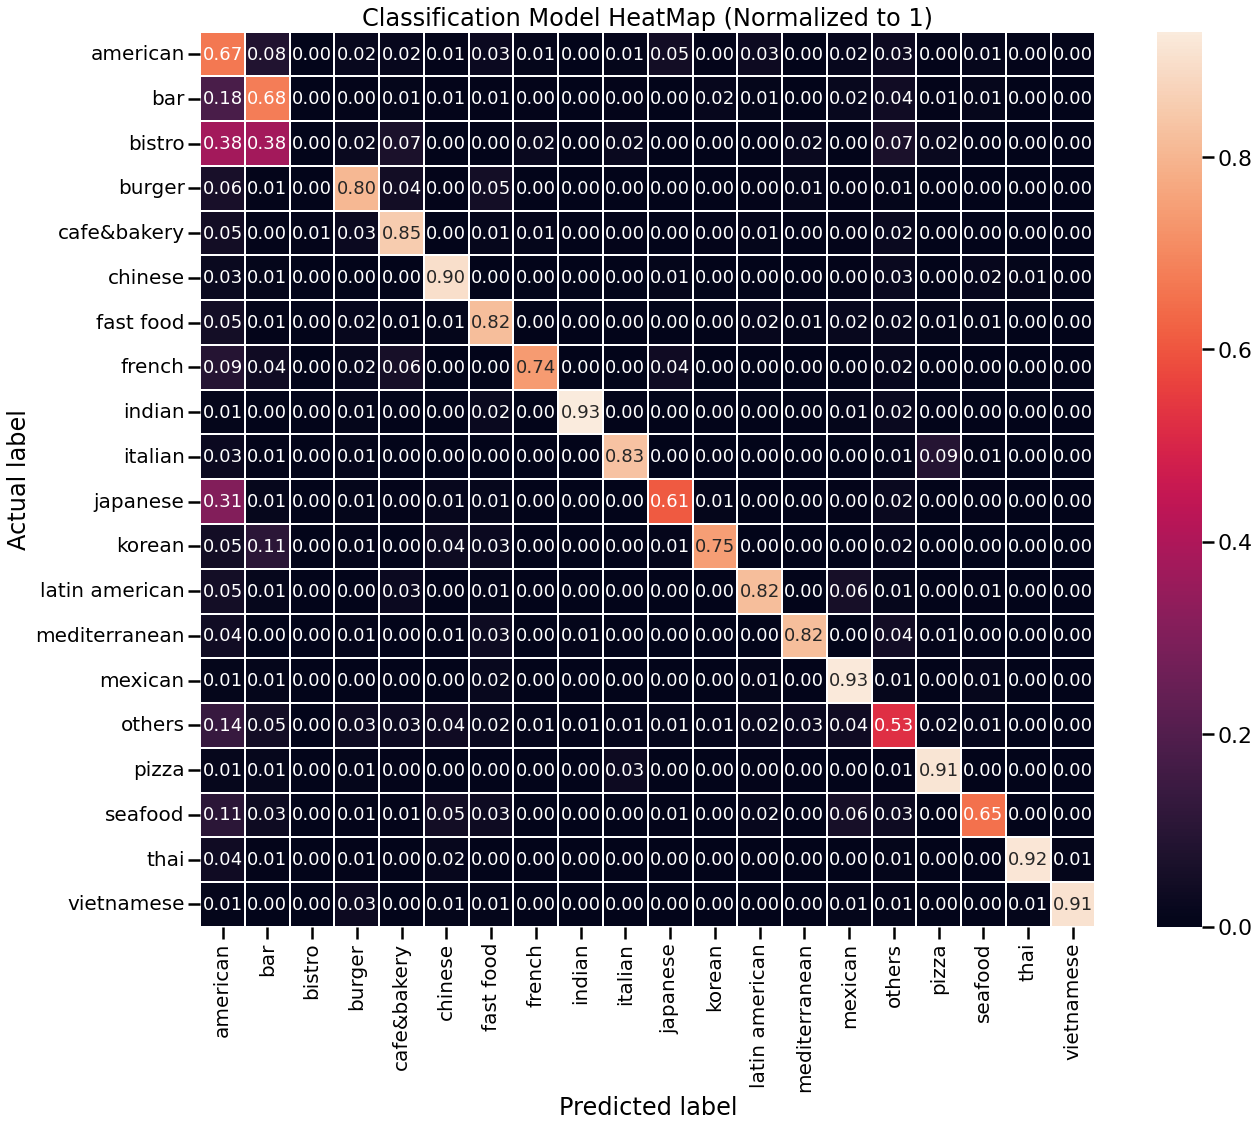

Accuracy: 78.23653774406168


In [38]:
import seaborn as sns
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, confusion_matrix

import seaborn as sns

fig = plt.figure(figsize=(20,16))

# fig.suptitle('Model Classification Heatmap Comparison\n\n',fontsize=30, x= 0.55, y = 0.9)

ax1 =  plot_heatmap_mat(y_tst,y_pred,normalize=True,classes = classes)
ax1.title.set_text('Classification Model HeatMap (Normalized to 1)')

# ax2 = plt.subplot(222); plot_heatmap_mat(y_tst,y_pred,normalize=True,classes = classes)
# ax2.title.set_text('LSTM_Bi Model Normalized')


plt.tight_layout()
plt.savefig('../data/output/classification_heatmap.png',format = 'png')

plt.show()
print('Accuracy: {}'.format(accuracy_score(y_tst,y_pred)*100))